In [ ]:
## 개별종목분석

from mod1 import *

def close_ma_vol(df,select1,select2,select3):
    ma(df)

    source = MinMaxScaler()
    data = source.fit_transform(df[['close',select1,select2,select3]].values)
    df1 = pd.DataFrame(data)
    df1.columns=['close',select1,select2,select3]
    df1 = df1.set_index(df['date'])
    df1.plot(figsize=(16,4))
    plt.title(df['name'][0])
    plt.grid(True)
    plt.show()    

name=['디엔에프','모트렉스','푸드나무','상보','아난티','손오공','한컴위드']

for i in name:
    df = select_stock(i,'2018-01-01')
    close_ma_vol(df,'ma60','ma120','volume')

In [ ]:
##  거래량 증가 관심종목 분석
from mod1 import *

def volume_group_analysis(path_volume,select_day):
    select_day = '2020-04-27'
    date = '2020-01-01'
    name = pd.read_excel(path_volume+select_day+'.xlsx', encoding='utf-8',index_col=0)
    name_all = name['Name']
    name_all = name_all.to_list()
    name = name[:5]

    for i in name_all:
        select_query = "select Date,Volume,Close from market where Name= "
        date_query = "Date > "
        var = select_query +"'"+i+"'"+" "+"&&"+" "+date_query+"'"+date+"'" 
        df = pd.read_sql(var, engine)
        df[['Volume','Close']] = df[['Volume','Close']].astype(float) #  TA-Lib로 평균을 구하려면 실수로 만들어야 함
        df.columns=df.columns.str.lower()

        talib_ma120 = ta.MA(df, timeperiod=20)
        df['ma20'] = talib_ma120

        source = MinMaxScaler()
        data = source.fit_transform(df[['close','volume','ma20']].values)
        df1 = pd.DataFrame(data)
        df1.columns=['close','volume','ma20']
        df1 = df1.set_index(df['date'])
        df1.plot(figsize=(16,2))
        plt.title(i)
        plt.show()
               
volume_group_analysis(path_price,'2020-04-28')

In [ ]:
##  가격 증가 관심종목 분석

from mod1 import *

def price_group_analysis(path_price,select_day):
    #select_day = '2020-04-27'
    date = '2020-01-01'
    name = pd.read_excel(path_volume+select_day+'.xlsx', encoding='utf-8',index_col=0)
    name_all = name['Name']
    name_all = name_all.to_list()
    name = name[:5]

    for i in name_all:
        select_query = "select Date,Volume,Close from market where Name= "
        date_query = "Date > "
        var = select_query +"'"+i+"'"+" "+"&&"+" "+date_query+"'"+date+"'" 
        df = pd.read_sql(var, engine)
        df[['Volume','Close']] = df[['Volume','Close']].astype(float) #  TA-Lib로 평균을 구하려면 실수로 만들어야 함
        df.columns=df.columns.str.lower()

        talib_ma120 = ta.MA(df, timeperiod=20)
        df['ma20'] = talib_ma120

        source = MinMaxScaler()
        data = source.fit_transform(df[['close','volume','ma20']].values)
        df1 = pd.DataFrame(data)
        df1.columns=['close','volume','ma20']
        df1 = df1.set_index(df['date'])
        df1.plot(figsize=(16,2))
        plt.title(i)
        plt.show()

price_group_analysis(path_price,'2020-04-27')

# stock_prediction

# first

x_train (76, 5, 3)
y_train (76,)
X_test (9, 5, 3)
y_test (9,)
Train Score: 0.00 MSE (0.00 RMSE)
Test Score: 0.00 MSE (0.00 RMSE)


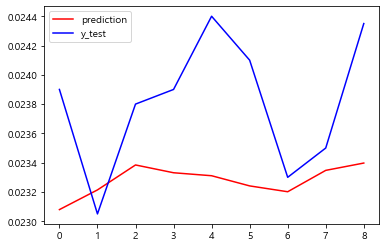

In [87]:
###  Keras_LSTM_Stock_Prediction#1

from mod1 import *
import math
import tensorflow as tf

df = select_stock('hrs','2020-01-01')
df=df[['Open','High','Close']]

df['High'] = df['High'] / 100000
df['Open'] = df['Open'] / 100000
df['Close'] = df['Close'] / 100000
df.head(5)

window = 5
amount_of_features = len(df.columns)
data = df.values #pd.DataFrame(stock)
sequence_length = window + 1
result = []

for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])

result = np.array(result)



row = round(0.9 * result.shape[0])
train = result[:int(row), :]
x_train = train[:, :-1]
y_train = train[:, -1][:,-1]
x_test = result[int(row):, :-1]
y_test = result[int(row):, -1][:,-1]

#x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
#x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("X_test", x_test.shape)
print("y_test", y_test.shape)


d = 0.2
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(window, 3), return_sequences=True))
model.add(tf.keras.layers.Dropout(d))
model.add(tf.keras.layers.LSTM(64, input_shape=(window, 3), return_sequences=False))
model.add(tf.keras.layers.Dropout(d))
model.add(tf.keras.layers.Dense(16,kernel_initializer="uniform",activation='relu'))        
model.add(tf.keras.layers.Dense(1,kernel_initializer="uniform",activation='relu'))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

model.fit(x_train,y_train,batch_size=10,epochs=100,validation_split=0.1,verbose=0)

trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(x_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

plt.plot(p,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

x_train (76, 5, 3)
y_train (76,)
x_test (9, 5, 3)
y_test (9,)
76/76 [==============================] - 0s 6ms/sample - loss: 0.0023 - accuracy: 0.0263
[[2422.50562]
 [2409.00635]
 [2304.68481]
 [2325.58301]
 [2386.65894]
 [2446.18359]
 [2445.64136]
 [2351.59229]
 [2303.06787]]
[[2390.00000]
 [2305.00000]
 [2380.00000]
 [2390.00000]
 [2440.00000]
 [2410.00000]
 [2330.00000]
 [2350.00000]
 [2435.00000]]


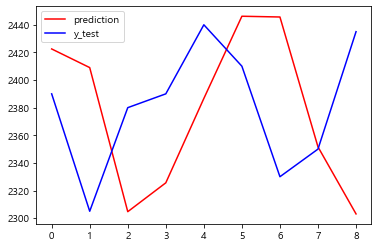

In [85]:
###  Keras_LSTM_Stock_Prediction#2


from mod1 import *
import math
import tensorflow as tf

df = select_stock('hrs','2020-01-01')
df=df[['Open','High','Close']]

scaler = MinMaxScaler()

window = 5
amount_of_features = len(df.columns)
data = df.values #pd.DataFrame(stock)
data = scaler.fit_transform(data)
sequence_length = window + 1
result = []

for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])
                  
result = np.array(result)

row = round(0.9 * result.shape[0])
train = result[:int(row), :]

x_train = train[:, :-1]
y_train = train[:, -1][:,-1]
x_test = result[int(row):, :-1]
y_test = result[int(row):, -1][:,-1]

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

d = 0.2
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(window, 3), return_sequences=True))
model.add(tf.keras.layers.Dropout(d))
model.add(tf.keras.layers.LSTM(64, input_shape=(window, 3), return_sequences=False))
model.add(tf.keras.layers.Dropout(d))
model.add(tf.keras.layers.Dense(16,kernel_initializer="uniform",activation='relu'))        
model.add(tf.keras.layers.Dense(1,kernel_initializer="uniform",activation='relu'))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

model.fit(x_train,y_train,batch_size=10,epochs=500,verbose=0)
model.evaluate(x_train, y_train)

pred = model.predict(x_test) 
#pred = [[0.69005],[0.61538],[0.60407],[0.63575],[0.62443]]  ## 테스트용으로 종가 5일치를 역순으로 
scale= MinMaxScaler()
scale.min_, scale.scale_=scaler.min_[2], scaler.scale_[2]   ##  Open열[0],High열[1] ~ Close열은 [4]
pred = scale.inverse_transform(pred)
print(pred)

true = y_test.reshape(-1,1)
true = scale.inverse_transform(true)
print(true)

plt.plot(pred,color='red', label='prediction')
plt.plot(true,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

# Second

trainX (58, 5, 5)
trainY (58, 5, 5)
testX (28, 5, 5)
testY (28, 1)
58/58 [==============================] - 0s 172us/sample - loss: 0.0081 - accuracy: 0.0345
[[1453.28394]
 [1512.62170]
 [1577.90845]
 [1649.29761]
 [1713.26941]
 [1780.07568]
 [1886.51160]
 [1927.73340]
 [1958.03503]
 [1969.91626]
 [1995.62207]
 [2034.22412]
 [2120.68652]
 [2223.59546]
 [2261.01660]
 [2245.18823]
 [2237.40063]
 [2233.75317]
 [2338.31274]
 [2366.34595]
 [2350.81006]
 [2356.38965]
 [2346.20068]
 [2364.68701]
 [2394.48901]
 [2412.50391]
 [2391.06787]
 [2376.62598]]
[[2005.00000]
 [2015.00000]
 [2100.00000]
 [2095.00000]
 [2110.00000]
 [2165.00000]
 [2155.00000]
 [2125.00000]
 [2170.00000]
 [2230.00000]
 [2270.00000]
 [2295.00000]
 [2330.00000]
 [2285.00000]
 [2310.00000]
 [2380.00000]
 [2370.00000]
 [2435.00000]
 [2390.00000]
 [2305.00000]
 [2380.00000]
 [2390.00000]
 [2440.00000]
 [2410.00000]
 [2330.00000]
 [2350.00000]
 [2435.00000]
 [2530.00000]]


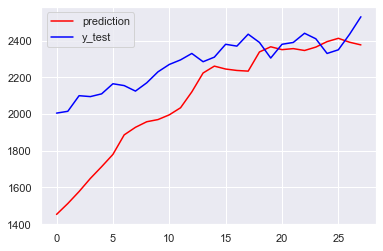

In [91]:
## Model Save - MinMaxScaler.fit 

import tensorflow as tf
import seaborn as sns
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

tf.random.set_seed(777)  # reproducibility

df = select_stock('hrs','2020-01-01')
df = df[['Open','High','Low','Volume','Close']]
xy = df.values

test_min = np.min(xy, 0)
test_max = np.max(xy, 0)
test_denom = test_max - test_min


seq_length = 5
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 9000

minmax = MinMaxScaler().fit(df.astype('float64')) # Close index
dataset = minmax.transform(df.astype('float64')) # Close index

train_size = int(len(dataset) * 0.7)
train_set = dataset[0:train_size]
test_set = dataset[train_size-seq_length:]  # Index from [train_size - seq_leng

# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        #print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

print("trainX", trainX.shape)
print("trainY", trainX.shape)
print("testX", testX.shape)
print("testY", testY.shape)


d = 0.2
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(5, 5), return_sequences=True))
model.add(tf.keras.layers.Dropout(d))
model.add(tf.keras.layers.LSTM(64, input_shape=(5, 5), return_sequences=False))
model.add(tf.keras.layers.Dropout(d))
model.add(tf.keras.layers.Dense(16,kernel_initializer="uniform",activation='relu'))        
model.add(tf.keras.layers.Dense(1,kernel_initializer="uniform",activation='relu'))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

model.fit(trainX, trainY,batch_size=10,epochs=100,validation_split=0.1,verbose=0)

model.evaluate(trainX, trainY)

pred = model.predict(testX) 
#pred = [[0.69005],[0.61538],[0.60407],[0.63575],[0.62443]]  ## 테스트용으로 종가 5일치를 역순으로 
scale= MinMaxScaler()
scale.min_, scale.scale_=minmax.min_[4], minmax.scale_[4]   ##  Open열[0],High열[1] ~ Close열은 [4]
pred = scale.inverse_transform(pred)
print(pred)

true = testY.reshape(-1,1)
true = scale.inverse_transform(true)
print(true)

plt.plot(pred,color='red', label='prediction')
plt.plot(true,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

####################################################################################################
58/58 [==============================] - 0s 172us/sample - loss: 0.0081 - accuracy: 0.0345
Train Score: 0.01 MSE (0.09 RMSE)
Test Score: 0.01 MSE (0.12 RMSE)


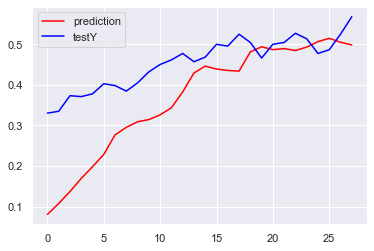

In [92]:
'''
This script shows how to predict stock prices using a basic RNN
'''
import tensorflow as tf
import seaborn as sns
from tqdm import tqdm


tf.random.set_seed(777) 

df = select_stock('hrs','2020-01-01')
df = df[['Open','High','Low','Volume','Close']]
xy = df.values


# train Parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 1000

scaler = MinMaxScaler()
dataset = scaler.fit_transform(xy)

# train/test split
train_size = int(len(dataset) * 0.7)
pre_train_set = dataset[0:train_size]
pre_test_set = dataset[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence

#최종 7 rows 다음날 Price Predict 입력 data
last_X = scaler.fit_transform((xy[-seq_length:,:]))


# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        #print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainx, trainy = build_dataset(pre_train_set, seq_length)
print("#"*100)
testx, testy = build_dataset(pre_test_set, seq_length)

d = 0.2
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(5, 5), return_sequences=True))
model.add(tf.keras.layers.Dropout(d))
model.add(tf.keras.layers.LSTM(64, input_shape=(5, 5), return_sequences=False))
model.add(tf.keras.layers.Dropout(d))
model.add(tf.keras.layers.Dense(16,kernel_initializer="uniform",activation='relu'))        
model.add(tf.keras.layers.Dense(1,kernel_initializer="uniform",activation='relu'))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

model.fit(trainX, trainY,batch_size=10,epochs=100,validation_split=0.1,verbose=0)

trainScore = model.evaluate(trainX, trainY, verbose=1)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

# print(X_test[-1])
diff=[]
ratio=[]
predict=[]
p = model.predict(testX)
for u in range(len(testY)):
    pr = p[u][0]
    ratio.append((testY[u]/pr)-1)
    diff.append(abs(testY[u]- pr))
    predict.append(pr)
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

plt.plot(p,color='red', label='prediction')
plt.plot(testY,color='blue', label='testY')
plt.legend(loc='upper left')
plt.show()

# Third

In [3]:
from mod1 import *
import tensorflow as tf

df = select_stock('hrs','2010-01-01')
# Line 9 to 17 is for preprocessing and saving the dataset downloaded from yahoo website
# It is not necessary to run these codes if you are using provided dataset in repo.
# If you want to use your own dataset downloaded from yahoo then first run these with commented rest.
# After that you can run as usual provided.

# df = df.drop(['Date'],axis=1)
# for col in df:
#     for i,item in enumerate(df[col]):
#         if item=='null':
#             df[col][i] = np.nan
# df = df.dropna(inplace=False)
# for col in df:
#     print(df[col].isnull().sum())
# df.to_csv('yah.csv',index=False)

df = df.drop(['Date','Code','Name','Volume'],axis=1)


df_train = df[:1059]
df_test = df[1059:]
scaler = MinMaxScaler()

X_train = scaler.fit_transform(df_train.drop(['Close'],axis=1).values)
y_train = scaler.fit_transform(df_train['Close'].values.reshape(-1, 1))


X_test = scaler.fit_transform(df_test.drop(['Close'],axis=1).values)
y_test = scaler.fit_transform(df_test['Close'].values.reshape(-1, 1))
#y_test = df_test['Close'].as_matrix()
print(X_train.shape)
print(np.max(y_test),np.max(y_train),np.min(y_test),np.min(y_train))

def denormalize(df,norm_data):
    df = df['Close'].values.reshape(-1,1)
    norm_data = norm_data.reshape(-1,1)
    scl = MinMaxScaler()
    a = scl.fit_transform(df)
    new = scl.inverse_transform(norm_data)
    return new

def neural_net_model(X_data,input_dim):
    W_1 = tf.Variable(tf.random_uniform([input_dim,10]))
    b_1 = tf.Variable(tf.zeros([10]))
    layer_1 = tf.add(tf.matmul(X_data,W_1), b_1)
    layer_1 = tf.nn.tanh(layer_1)

    W_2 = tf.Variable(tf.random_uniform([10,10]))
    b_2 = tf.Variable(tf.zeros([10]))
    layer_2 = tf.add(tf.matmul(layer_1,W_2), b_2)
    layer_2 = tf.nn.tanh(layer_2)

    W_O = tf.Variable(tf.random_uniform([10,1]))
    b_O = tf.Variable(tf.zeros([1]))
    output = tf.add(tf.matmul(layer_2,W_O), b_O)

    return output,W_O

(1059, 3)
1.0 1.0 0.0 0.0


ValueError: Error when checking input: expected lstm_6_input to have 3 dimensions, but got array with shape (1059, 3)

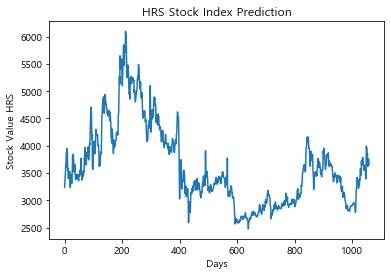

In [10]:
y_t = denormalize(df_train,y_train)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.xlabel('Days')
plt.ylabel('Stock Value HRS')
plt.title('HRS Stock Index Prediction')
ax.plot(range(len(y_train)), y_t,label='Original')
plt.ion()


d = 0.2
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(1, 3), return_sequences=True))
model.add(tf.keras.layers.Dropout(d))
model.add(tf.keras.layers.LSTM(64, input_shape=(1, 3), return_sequences=False))
model.add(tf.keras.layers.Dropout(d))
model.add(tf.keras.layers.Dense(16,kernel_initializer="uniform",activation='relu'))        
model.add(tf.keras.layers.Dense(1,kernel_initializer="uniform",activation='relu'))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

model.fit(X_train, y_train,batch_size=10,epochs=100,validation_split=0.1,verbose=0)


In [13]:
X_train.ndim

2

In [9]:
df['Close'].values.reshape(-1,1)

array([[3235],
       [3295],
       [3425],
       ...,
       [2350],
       [2435],
       [2530]], dtype=int64)

In [10]:
def aaa(norm_data):
    norm_data = norm_data.reshape(-1,1)
    scl = MinMaxScaler()
    new = scl.inverse_transform(norm_data)
    return new

(1059, 3)
1.0 1.0 0.0 0.0


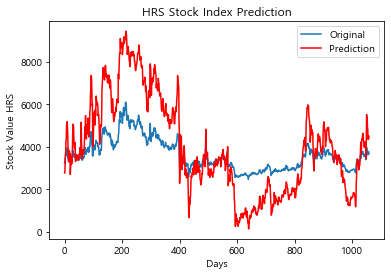

Epoch : 0 Cost : 0.18410094


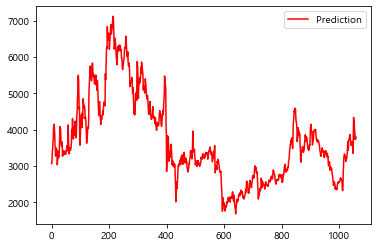

Epoch : 1 Cost : 0.016220627


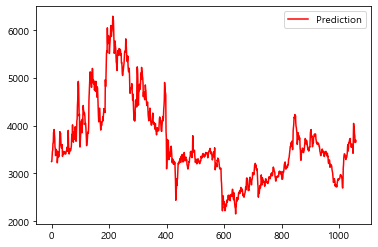

Epoch : 2 Cost : 0.0017213617


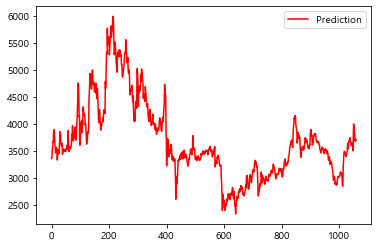

Epoch : 3 Cost : 0.0010764764


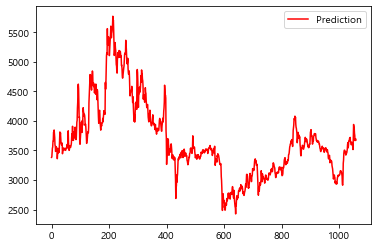

Epoch : 4 Cost : 0.0015558909


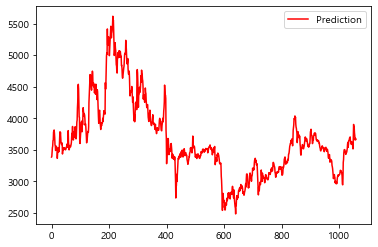

Epoch : 5 Cost : 0.0021151113


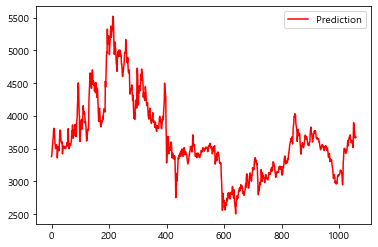

Epoch : 6 Cost : 0.0023568647


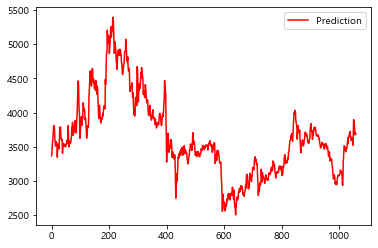

Epoch : 7 Cost : 0.0026134886


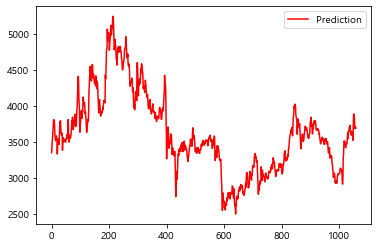

Epoch : 8 Cost : 0.003026744


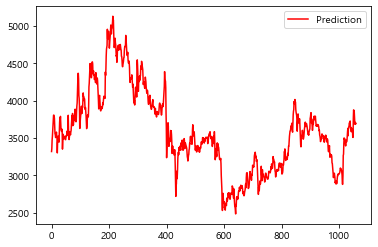

Epoch : 9 Cost : 0.0033737982


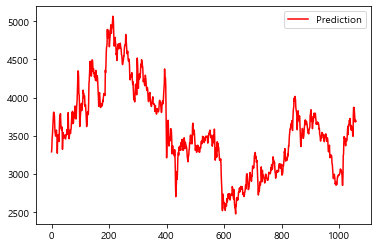

Epoch : 10 Cost : 0.0035303626


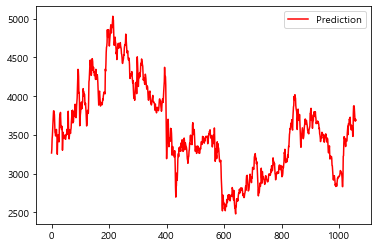

Epoch : 11 Cost : 0.0035641685


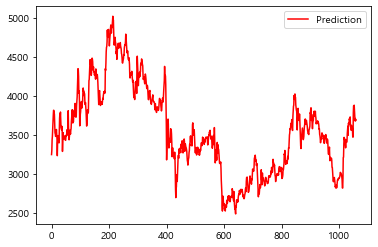

Epoch : 12 Cost : 0.00352624


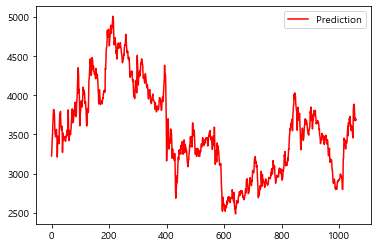

Epoch : 13 Cost : 0.0035031075


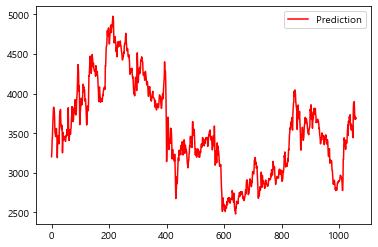

Epoch : 14 Cost : 0.003478879


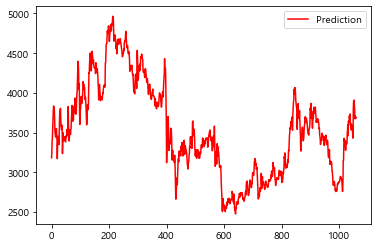

Epoch : 15 Cost : 0.0032125432


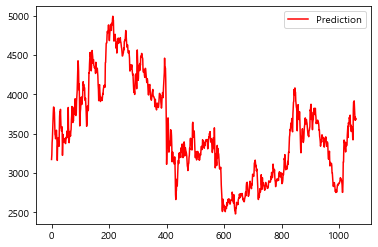

Epoch : 16 Cost : 0.0028634558


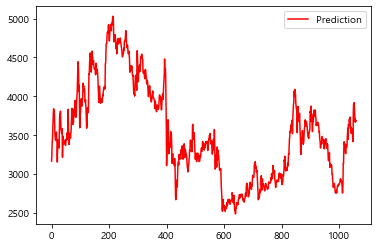

Epoch : 17 Cost : 0.0026046822


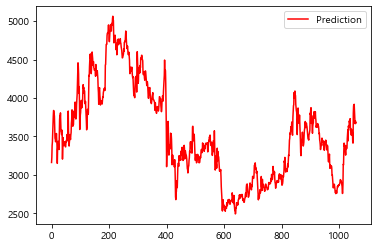

Epoch : 18 Cost : 0.0024238972


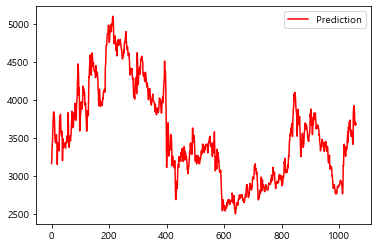

Epoch : 19 Cost : 0.0022562656


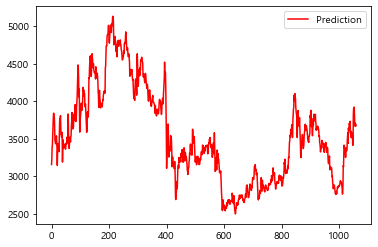

Epoch : 20 Cost : 0.002100885


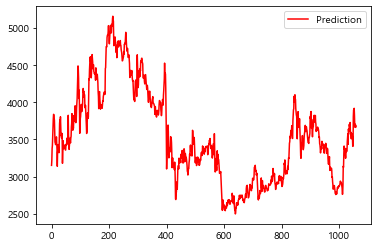

Epoch : 21 Cost : 0.0019623162


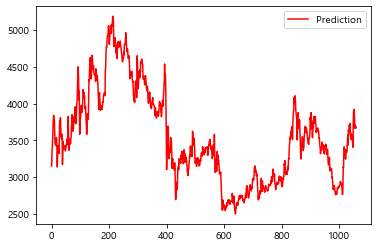

Epoch : 22 Cost : 0.0018389939


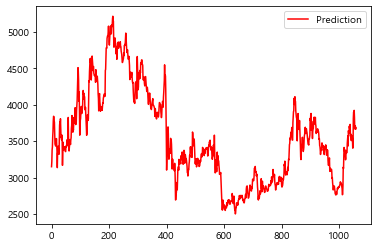

Epoch : 23 Cost : 0.0017333736


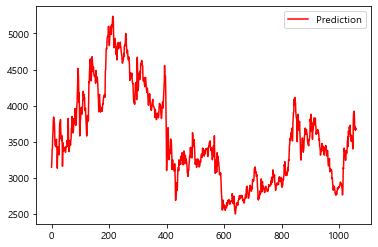

Epoch : 24 Cost : 0.0016414757


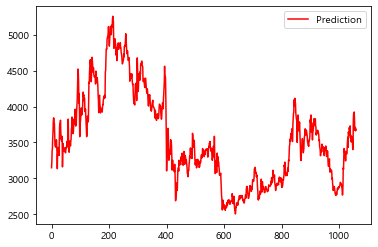

Epoch : 25 Cost : 0.0015611754


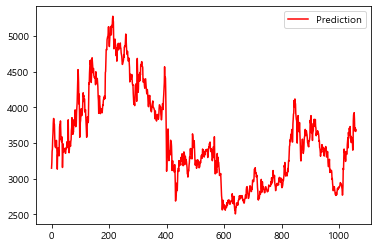

Epoch : 26 Cost : 0.0014902656


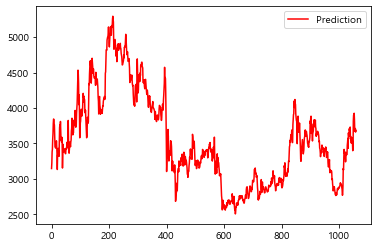

Epoch : 27 Cost : 0.0014307629


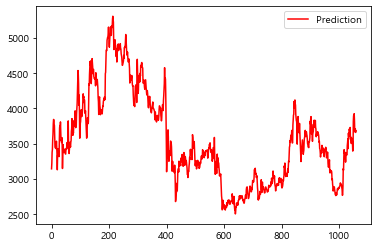

Epoch : 28 Cost : 0.0013884163


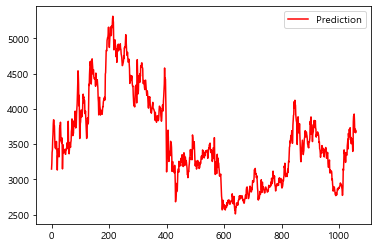

Epoch : 29 Cost : 0.0013589069


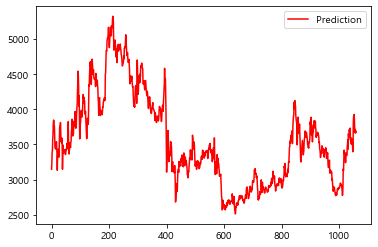

Epoch : 30 Cost : 0.0013228998


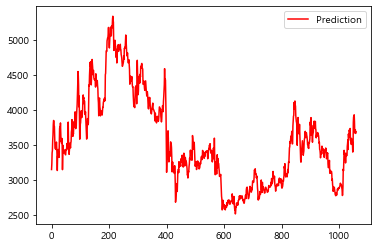

Epoch : 31 Cost : 0.001279451


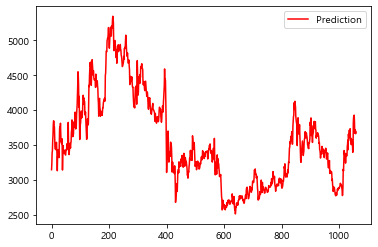

Epoch : 32 Cost : 0.0012492721


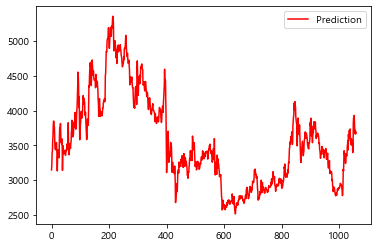

Epoch : 33 Cost : 0.0012190911


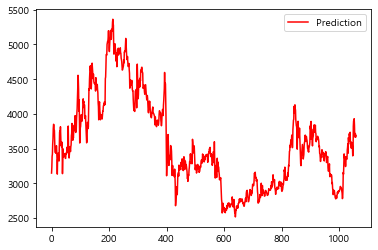

Epoch : 34 Cost : 0.0011925541


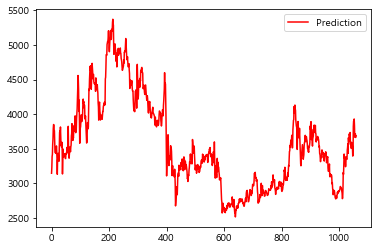

Epoch : 35 Cost : 0.0011672647


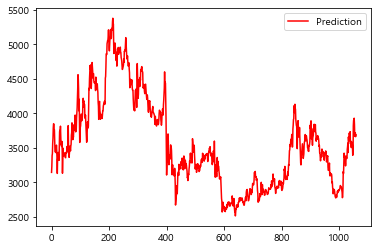

Epoch : 36 Cost : 0.001144278


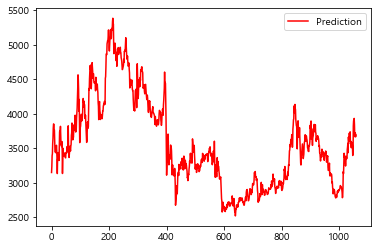

Epoch : 37 Cost : 0.0011229308


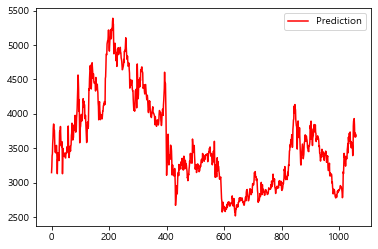

Epoch : 38 Cost : 0.0011030289


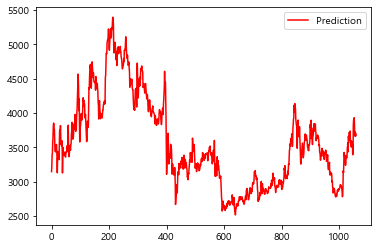

Epoch : 39 Cost : 0.0010866794


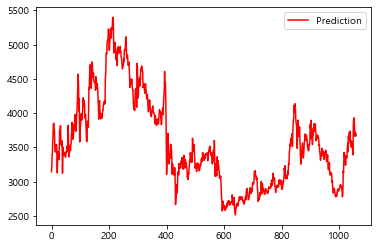

Epoch : 40 Cost : 0.0010747655


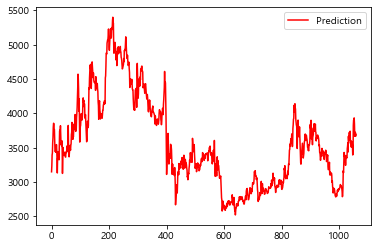

Epoch : 41 Cost : 0.0010713637


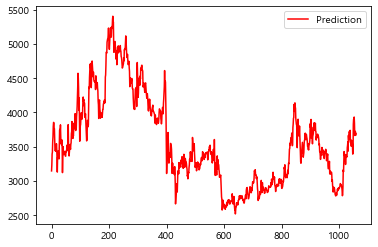

Epoch : 42 Cost : 0.0010471469


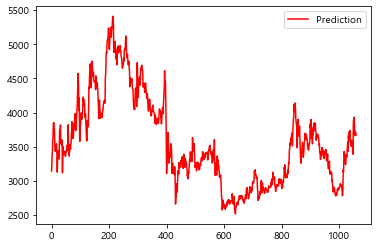

Epoch : 43 Cost : 0.0010292752


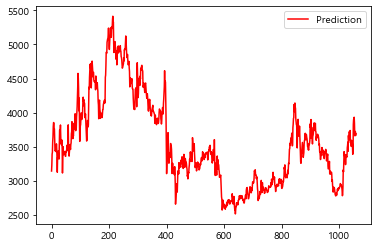

Epoch : 44 Cost : 0.0010200937


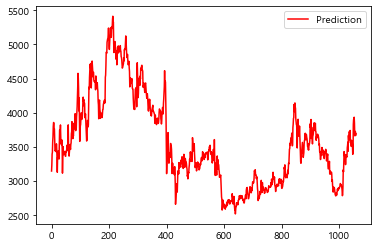

Epoch : 45 Cost : 0.0010188747


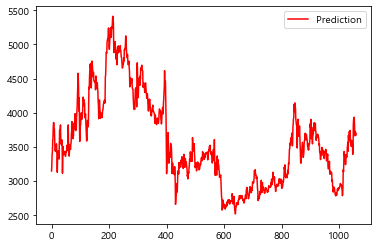

Epoch : 46 Cost : 0.0010160554


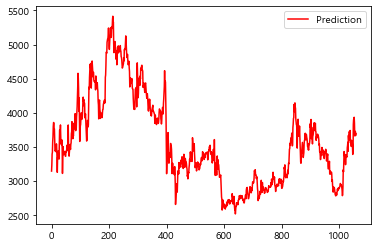

Epoch : 47 Cost : 0.0010013122


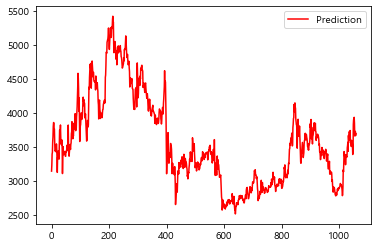

Epoch : 48 Cost : 0.0009908899


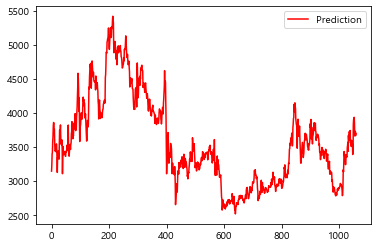

Epoch : 49 Cost : 0.0009908916


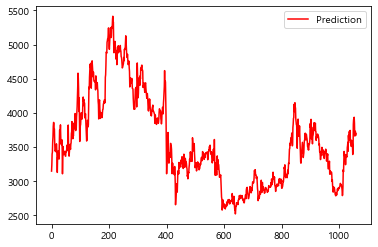

Epoch : 50 Cost : 0.0009954083


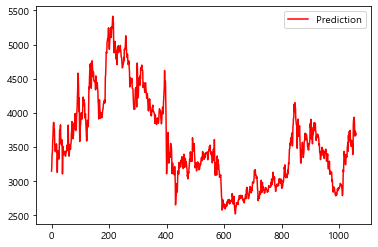

Epoch : 51 Cost : 0.0009869178


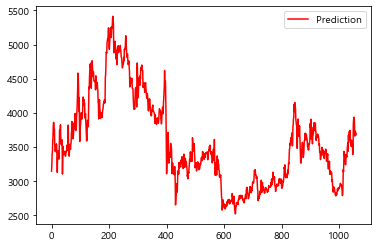

Epoch : 52 Cost : 0.0009853038


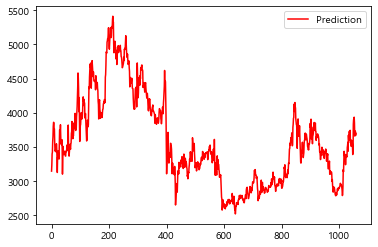

Epoch : 53 Cost : 0.0009868973


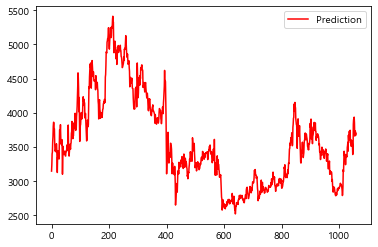

Epoch : 54 Cost : 0.0009881856


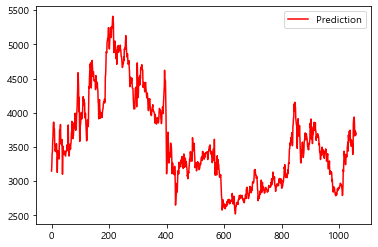

Epoch : 55 Cost : 0.0009839894


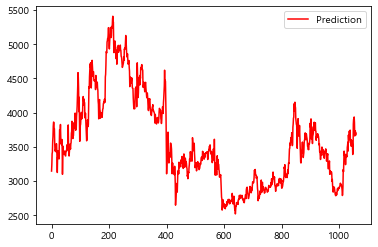

Epoch : 56 Cost : 0.0009803792


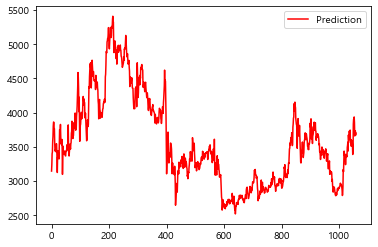

Epoch : 57 Cost : 0.00097393047


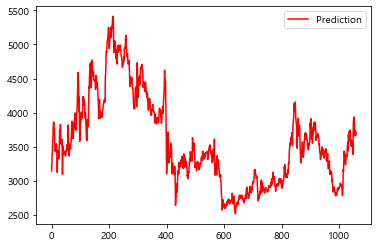

Epoch : 58 Cost : 0.00096327614


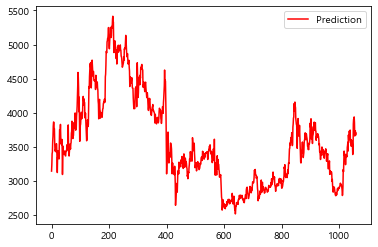

Epoch : 59 Cost : 0.00095242145


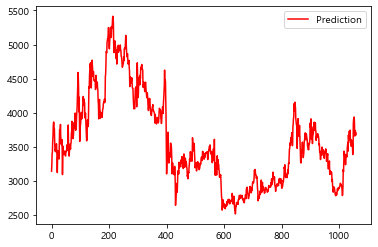

Epoch : 60 Cost : 0.00094837055


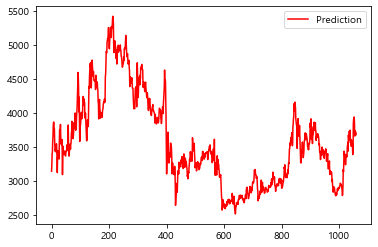

Epoch : 61 Cost : 0.00094464683


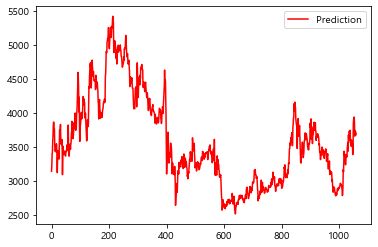

Epoch : 62 Cost : 0.00093873387


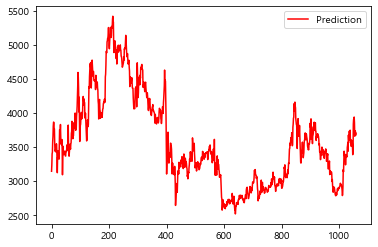

Epoch : 63 Cost : 0.00093953736


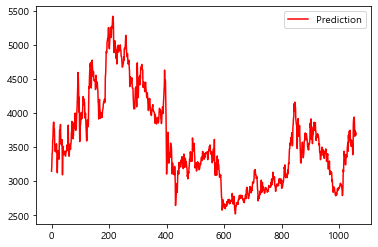

Epoch : 64 Cost : 0.0009318473


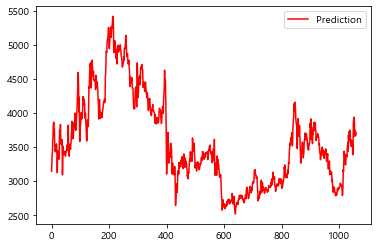

Epoch : 65 Cost : 0.00093521253


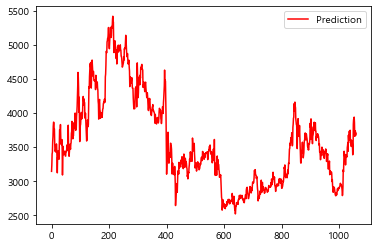

Epoch : 66 Cost : 0.0009296017


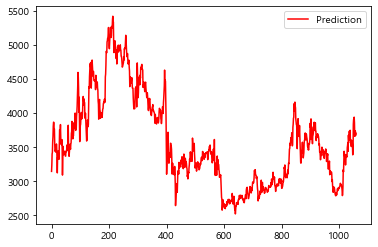

Epoch : 67 Cost : 0.0009323918


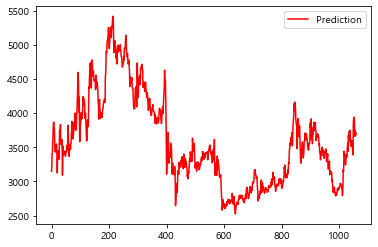

Epoch : 68 Cost : 0.0009307249


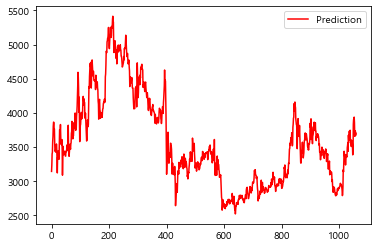

Epoch : 69 Cost : 0.0009295265


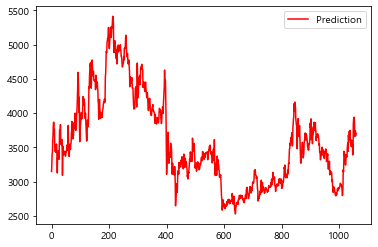

Epoch : 70 Cost : 0.0009284023


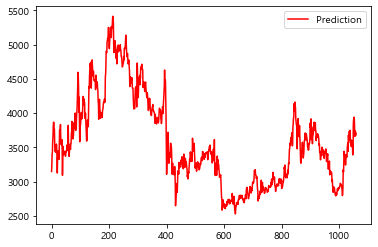

Epoch : 71 Cost : 0.0009309339


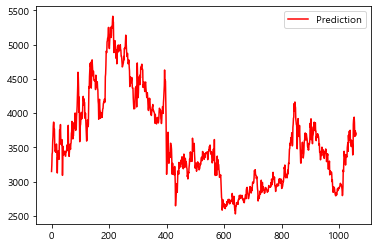

Epoch : 72 Cost : 0.0009292329


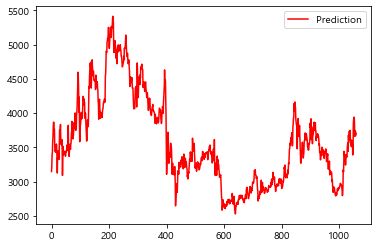

Epoch : 73 Cost : 0.00092545926


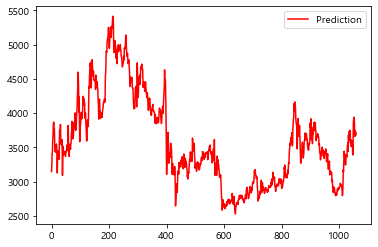

Epoch : 74 Cost : 0.00092701014


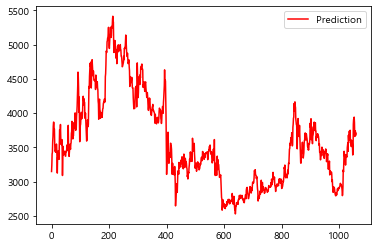

Epoch : 75 Cost : 0.00092517294


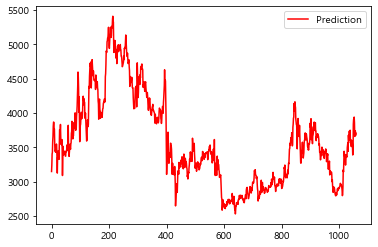

Epoch : 76 Cost : 0.0009284373


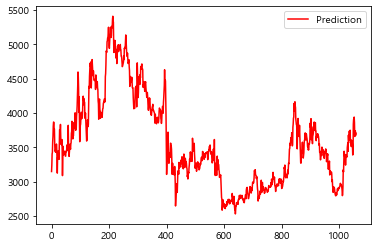

Epoch : 77 Cost : 0.0009252823


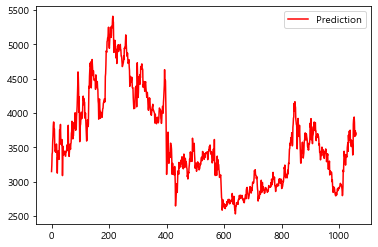

Epoch : 78 Cost : 0.0009262434


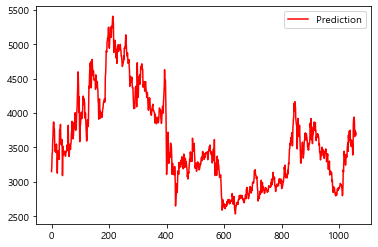

Epoch : 79 Cost : 0.0009292023


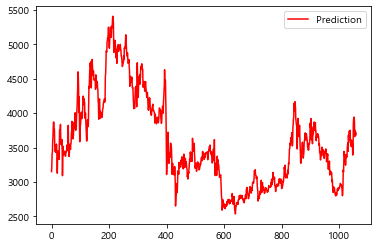

Epoch : 80 Cost : 0.00092304824


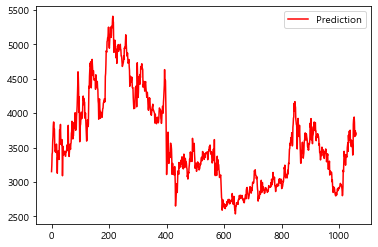

Epoch : 81 Cost : 0.00092173653


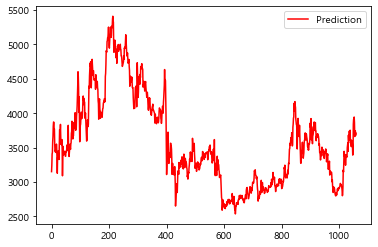

Epoch : 82 Cost : 0.00092567387


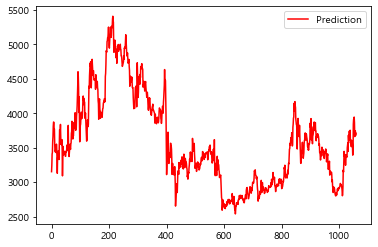

Epoch : 83 Cost : 0.0009202232


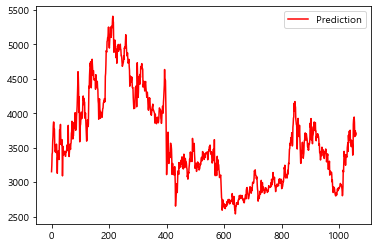

Epoch : 84 Cost : 0.00091840007


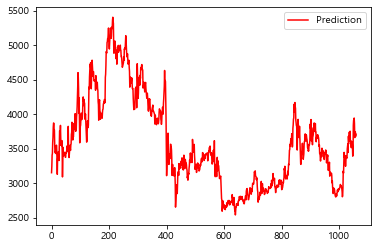

Epoch : 85 Cost : 0.0009240047


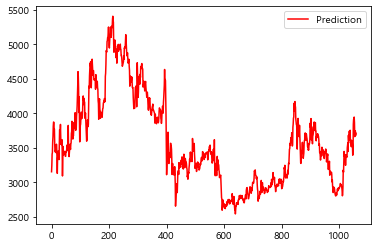

Epoch : 86 Cost : 0.0009162904


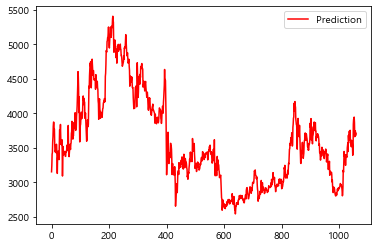

Epoch : 87 Cost : 0.0009062452


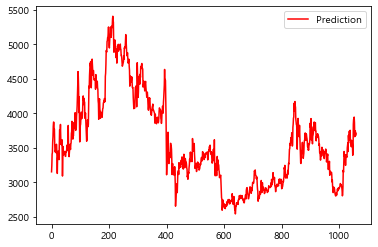

Epoch : 88 Cost : 0.0009003736


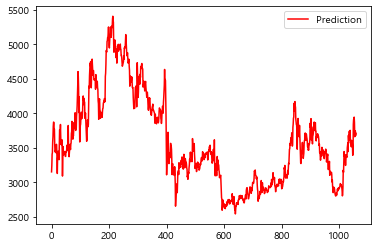

Epoch : 89 Cost : 0.00089813437


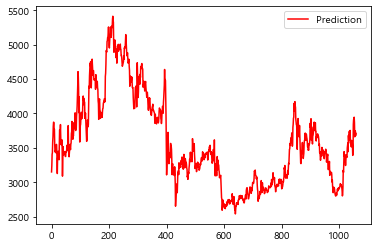

Epoch : 90 Cost : 0.00088987336


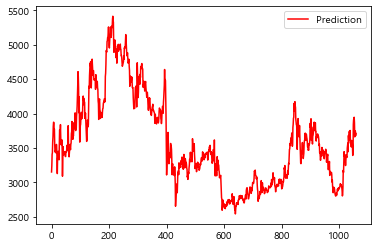

Epoch : 91 Cost : 0.00088152284


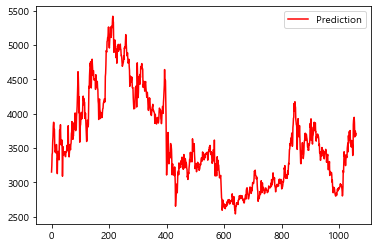

Epoch : 92 Cost : 0.00087293814


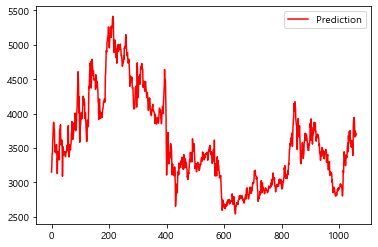

Epoch : 93 Cost : 0.00087353523


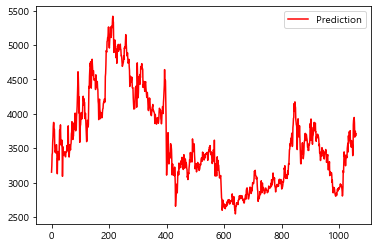

Epoch : 94 Cost : 0.00086615514


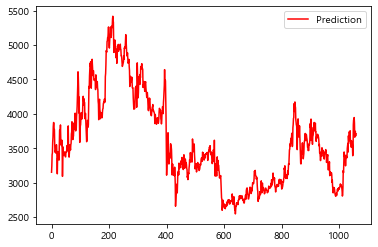

Epoch : 95 Cost : 0.0008623331


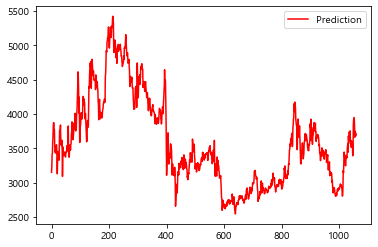

Epoch : 96 Cost : 0.0008486721


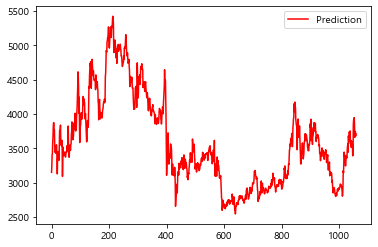

Epoch : 97 Cost : 0.00085308176


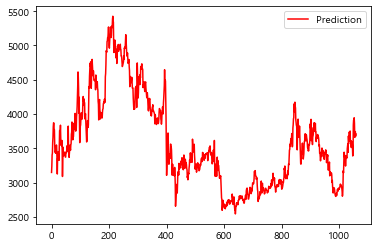

Epoch : 98 Cost : 0.000842019


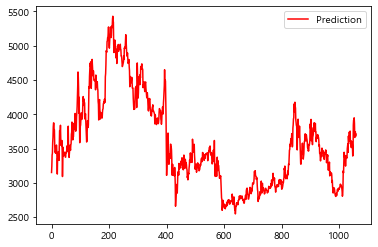

Epoch : 99 Cost : 0.0008334564
Original : [0.57344301] Predicted : [0.5432454]
Original : [0.59341951] Predicted : [0.5662821]
Original : [0.57344301] Predicted : [0.5502279]
Original : [0.57109283] Predicted : [0.5338306]
Original : [0.58166863] Predicted : [0.54596925]
Original : [0.58989424] Predicted : [0.5739239]
Original : [0.58754407] Predicted : [0.56710225]
Original : [0.5840188] Predicted : [0.5416719]
Original : [0.61692127] Predicted : [0.5732285]
Original : [0.61692127] Predicted : [0.58828545]
Original : [0.613396] Predicted : [0.5692929]
Original : [0.61692127] Predicted : [0.57636267]
Original : [0.60164512] Predicted : [0.56552416]
Original : [0.58636898] Predicted : [0.54895824]
Original : [0.5746181] Predicted : [0.53361785]
Original : [0.56756757] Predicted : [0.54022163]
Original : [0.56991774] Predicted : [0.54254735]
Original : [0.57226792] Predicted : [0.55438226]
Original : [0.57226792] Predicted : [0.53701746]
Original : [0.54876616] Predicted : [0.5294753]
Or

Original : [0.60987074] Predicted : [0.56387055]
Original : [0.58166863] Predicted : [0.56112814]
Original : [0.53584019] Predicted : [0.5069806]
Original : [0.55934195] Predicted : [0.5281503]
Original : [0.55934195] Predicted : [0.53974354]
Original : [0.57109283] Predicted : [0.55644643]
Original : [0.56991774] Predicted : [0.54871726]
Original : [0.5746181] Predicted : [0.54758084]
Original : [0.57696827] Predicted : [0.5425925]
Original : [0.5840188] Predicted : [0.55085987]
Original : [0.5840188] Predicted : [0.54809487]
Original : [0.58166863] Predicted : [0.5517317]
Original : [0.58049354] Predicted : [0.55125546]
Original : [0.56991774] Predicted : [0.5294295]
Original : [0.56991774] Predicted : [0.5403655]
Original : [0.57579318] Predicted : [0.54666954]
Original : [0.5840188] Predicted : [0.54616225]
Original : [0.58754407] Predicted : [0.5517317]
Original : [0.57696827] Predicted : [0.5447028]
Original : [0.57696827] Predicted : [0.54905194]
Original : [0.57344301] Predicte

Original : [0.66274971] Predicted : [0.60970455]
Original : [0.67097532] Predicted : [0.6177993]
Original : [0.66157462] Predicted : [0.6233638]
Original : [0.66862515] Predicted : [0.6176565]
Original : [0.67097532] Predicted : [0.6180156]
Original : [0.68037603] Predicted : [0.6348222]
Original : [0.69917744] Predicted : [0.6407033]
Original : [0.70387779] Predicted : [0.64376146]
Original : [0.70505288] Predicted : [0.6422152]
Original : [0.693302] Predicted : [0.63534296]
Original : [0.7027027] Predicted : [0.6464155]
Original : [0.72972973] Predicted : [0.6506641]
Original : [0.73913043] Predicted : [0.6575249]
Original : [0.72972973] Predicted : [0.6632676]
Original : [0.73090482] Predicted : [0.6628626]
Original : [0.73678026] Predicted : [0.66031826]
Original : [0.72502938] Predicted : [0.6584215]
Original : [0.72502938] Predicted : [0.65310717]
Original : [0.74383079] Predicted : [0.6646316]
Original : [0.75558167] Predicted : [0.67437935]
Original : [0.75910693] Predicted : [

Original : [0.22679201] Predicted : [0.24404065]
Original : [0.22444183] Predicted : [0.22461371]
Original : [0.23501763] Predicted : [0.2267626]
Original : [0.2279671] Predicted : [0.22509223]
Original : [0.23031727] Predicted : [0.22788604]
Original : [0.24559342] Predicted : [0.2575395]
Original : [0.35370153] Predicted : [0.3348697]
Original : [0.33137485] Predicted : [0.33145028]
Original : [0.33372503] Predicted : [0.31822094]
Original : [0.31492362] Predicted : [0.31669736]
Original : [0.31257344] Predicted : [0.30489272]
Original : [0.32314924] Predicted : [0.31115517]
Original : [0.31962397] Predicted : [0.31728026]
Original : [0.28319624] Predicted : [0.2762951]
Original : [0.29377203] Predicted : [0.28798747]
Original : [0.28789659] Predicted : [0.28124824]
Original : [0.29259694] Predicted : [0.2841837]
Original : [0.30082256] Predicted : [0.29779592]
Original : [0.29259694] Predicted : [0.281819]
Original : [0.27497062] Predicted : [0.26722312]
Original : [0.26556992] Pred

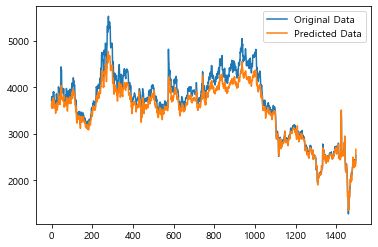

Save model ? [Y/N]N


In [15]:
##  Tensorflow 1.0

from mod1 import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior( )

df = select_stock('hrs','2010-01-01')
# Line 9 to 17 is for preprocessing and saving the dataset downloaded from yahoo website
# It is not necessary to run these codes if you are using provided dataset in repo.
# If you want to use your own dataset downloaded from yahoo then first run these with commented rest.
# After that you can run as usual provided.

# df = df.drop(['Date'],axis=1)
# for col in df:
#     for i,item in enumerate(df[col]):
#         if item=='null':
#             df[col][i] = np.nan
# df = df.dropna(inplace=False)
# for col in df:
#     print(df[col].isnull().sum())
# df.to_csv('yah.csv',index=False)

df = df.drop(['Date','Code','Name','Volume'],axis=1)


df_train = df[:1059]
df_test = df[1059:]
scaler = MinMaxScaler()

X_train = scaler.fit_transform(df_train.drop(['Close'],axis=1).values)
y_train = scaler.fit_transform(df_train['Close'].values.reshape(-1, 1))


X_test = scaler.fit_transform(df_test.drop(['Close'],axis=1).values)
y_test = scaler.fit_transform(df_test['Close'].values.reshape(-1, 1))
#y_test = df_test['Close'].as_matrix()
print(X_train.shape)
print(np.max(y_test),np.max(y_train),np.min(y_test),np.min(y_train))


def denormalize(df,norm_data):
    df = df['Close'].values.reshape(-1,1)
    norm_data = norm_data.reshape(-1,1)
    scl = MinMaxScaler()
    a = scl.fit_transform(df)
    new = scl.inverse_transform(norm_data)
    return new

def neural_net_model(X_data,input_dim):
    W_1 = tf.Variable(tf.random_uniform([input_dim,10]))
    b_1 = tf.Variable(tf.zeros([10]))
    layer_1 = tf.add(tf.matmul(X_data,W_1), b_1)
    layer_1 = tf.nn.tanh(layer_1)

    W_2 = tf.Variable(tf.random_uniform([10,10]))
    b_2 = tf.Variable(tf.zeros([10]))
    layer_2 = tf.add(tf.matmul(layer_1,W_2), b_2)
    layer_2 = tf.nn.tanh(layer_2)

    W_O = tf.Variable(tf.random_uniform([10,1]))
    b_O = tf.Variable(tf.zeros([1]))
    output = tf.add(tf.matmul(layer_2,W_O), b_O)

    return output,W_O

xs = tf.placeholder("float")
ys = tf.placeholder("float")

output,W_O = neural_net_model(xs,3)

cost = tf.reduce_mean(tf.square(output-ys))
train = tf.train.AdamOptimizer(0.001).minimize(cost)

correct_pred = tf.argmax(output, 1)
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

c_t = []
c_test = []


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    saver = tf.train.Saver()
    y_t = denormalize(df_train,y_train)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.xlabel('Days')
    plt.ylabel('Stock Value HRS')
    plt.title('HRS Stock Index Prediction')
    ax.plot(range(len(y_train)), y_t,label='Original')
    plt.ion()

    #saver.restore(sess,'yahoo_dataset.ckpt')
    for i in range(100):
        #sess.run([cost,train],feed_dict={xs:X_train, ys:y_train})
        for j in range(X_train.shape[0]):
            sess.run([cost,train],feed_dict={xs:X_train[j,:].reshape(1,3), ys:y_train[j]})

        try:
            ax.lines.remove(lines[0])
        except Exception:
            pass
        pred = sess.run(output, feed_dict={xs:X_train})
        pred = denormalize(df_train,pred)
        plt.plot(range(len(y_train)), pred,'r-',label='Prediction')
        plt.legend(loc='best')
        plt.pause(0.1)

        c_t.append(sess.run(cost, feed_dict={xs:X_train,ys:y_train}))
        c_test.append(sess.run(cost, feed_dict={xs:X_test,ys:y_test}))
        print('Epoch :',i,'Cost :',c_t[i])

    pred = sess.run(output, feed_dict={xs:X_test})
    for i in range(y_test.shape[0]):
        print('Original :',y_test[i],'Predicted :',pred[i])

    #plt.plot(range(50),c_t)
    #plt.plot(range(50),c_test)
    #plt.show()

    print('Cost :',sess.run(cost, feed_dict={xs:X_test,ys:y_test}))
    y_test = denormalize(df_test,y_test)
    pred = denormalize(df_test,pred)
    plt.plot(range(y_test.shape[0]),y_test,label="Original Data")
    plt.plot(range(y_test.shape[0]),pred,label="Predicted Data")
    plt.legend(loc='best')
    """plt.ylabel('Stock Value')
    plt.xlabel('Days')
    plt.title('Stock Market Nifty')"""
    plt.show()
    if input('Save model ? [Y/N]') == 'Y':
        import os
        saver.save(sess, os.getcwd() + '/yahoo_dataset.ckpt')
        print('Model Saved')

# 데이타 전처리

In [63]:
from mod1 import *

df = select_stock('hrs','2020-01-01')
df = df[['Open','High','Low','Volume','Close']]
print(df.head())

# 결과확인을 위해 소수 출력 옵션 변경 소수 첫째자리까지
np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.5f}".format(x)}) 

data = df.values

scaler = MinMaxScaler()

data_a =scaler.fit_transform(data)               ## 전처리 
print(data_a[:5])

data_b = scaler.inverse_transform(data_a)        ## 전체 복원
print(data_b[:5])

data_c = scaler.inverse_transform(data_a)[:, [0]] ##  Open열만 복원,  Close열은 [4]
data_c[:5]

### 주식 예측값 배열이 생성 되었을때 실제 Close와 비교하기

#pred = model.predict(test_X) 
pred = [[0.69005],[0.61538],[0.60407],[0.63575],[0.62443]]  ## 테스트용으로 종가 5일치를 역순으로 
scale= MinMaxScaler()
scale.min_, scale.scale_=scaler.min_[4], scaler.scale_[4]   ##  Open열[0],High열[1] ~ Close열은 [4]
data_d = scale.inverse_transform(pred)
print(data_d)

   Open  High   Low   Volume  Close
0  2675  2675  2640    70066   2655
1  2655  2690  2655    75018   2680
2  2650  2680  2600    74714   2610
3  2605  2645  2605    43743   2635
4  2630  3025  2545  5063029   2800
[[0.61674 0.49505 0.69114 0.00148 0.62443]
 [0.60793 0.50099 0.69873 0.00174 0.63575]
 [0.60573 0.49703 0.67089 0.00172 0.60407]
 [0.58590 0.48317 0.67342 0.00015 0.61538]
 [0.59692 0.63366 0.64304 0.25518 0.69005]]
[[2675.00000 2675.00000 2640.00000 70066.00000 2655.00000]
 [2655.00000 2690.00000 2655.00000 75018.00000 2680.00000]
 [2650.00000 2680.00000 2600.00000 74714.00000 2610.00000]
 [2605.00000 2645.00000 2605.00000 43743.00000 2635.00000]
 [2630.00000 3025.00000 2545.00000 5063029.00000 2800.00000]]
[[2800.01050]
 [2634.98980]
 [2609.99470]
 [2680.00750]
 [2654.99030]]


In [ ]:
import numpy as np
print(np.__version__) # 1.16.4

# 결과확인을 위해 소수 출력 옵션 변경
np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.1f}".format(x)}) 

from sklearn.preprocessing import MinMaxScaler

t1 =  np.array([
                    [ 1,    1000],
                    [ 5,   10000],
                    [10,  100000],
               ])
t2 =  np.array([
                    [  2,    100],
                    [ 15,  20000],
                    [100, 300000],
               ])

scaler = MinMaxScaler()

scaler.fit(t1)
print(scaler.n_samples_seen_, scaler.data_min_, scaler.data_max_, scaler.feature_range)
# > 3 [1.0 1000.0] [10.0 100000.0] (0, 1)

scaler.partial_fit(t2) # 추가 피팅
print(scaler.n_samples_seen_, scaler.data_min_, scaler.data_max_, scaler.feature_range)
# > 6 [1.0 100.0] [100.0 300000.0] (0, 1)

t2_prinme = scaler.transform(t2)
# array([[0.0, 0.0],
#        [0.1, 0.1],
#        [1.0, 1.0]])
print(t2_prinme)

t2_prime_prime = scaler.inverse_transform(t2_prinme)
#  array([[  2.0,    100.0],
#         [ 15.0,  20000.0],
#         [100.0, 300000.0]])
print(t2_prime_prime)


### https://m.blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221614354947&proxyReferer=https:%2F%2Fwww.google.com%2F

In [ ]:
##  reshape(-1)의 의미  : 가변적이다

x = np.arange(12)
print(x)

print(x.reshape(-1,1))  ## 행,열중 열이  1열이므로 12행이된다
print(x.reshape(-1,2))  ## 열이 2열이므로 6행이 된다

print(x.reshape(1,-1))  ## 행,열중 행이 1행이므로 열이 12열이 된다
print(x.reshape(2,-1))  ## 행,열중 행이 2행이므로 열이 6열이 된다